In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report


In [69]:
#load up titanic.csv

df = pd.read_csv("titanic.csv")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap to multiple lines
#Checking data output and some statistical information
print(df.head())
print(df.describe())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [70]:
#handle missing data and change add dummy columns for Embarked

print("\nTotal missing per Column\n")
missing_count = df.isnull().sum()
print(missing_count)

#dropping cabin since majority of records are blank
df.drop('Cabin', axis=1, inplace=True)

#Not too many are missing and took the median
df['Age'] = df['Age'].fillna(df['Age'].median())  # Replace with median age

#Replacing missing data with highest count
df["Embarked"] = df["Embarked"].fillna('S')
# Double-check to make sure there are no more missing values
print(df['Embarked'].value_counts(dropna=False))




Total missing per Column

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [71]:
#Create dummy columns for Embarked
# Step 1: Initialize the encoder
encoder = OneHotEncoder(categories=[['S', 'C', 'Q']], drop='first', sparse_output=False)

# Step 2: Fit + transform the column
embarked_encoded = encoder.fit_transform(df[['Embarked']])

# Step 3: Turn result into a DataFrame with meaningful column names
embarked_df = pd.DataFrame(
    embarked_encoded,
    columns=encoder.get_feature_names_out(['Embarked']),
    index=df.index
)

# Step 4: Concatenate back to original df (drop original column first)
df = pd.concat([df.drop(columns=['Embarked']), embarked_df], axis=1)


# Map 'male' to 0, 'female' to 1
df['Sex_encoded'] = df['Sex'].map({'male': 0, 'female': 1})

# Check it worked
df[['Sex', 'Sex_encoded']].head()


print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare  Embarked_C  Embarked_Q  Sex_encoded  
0      0         A/5 21171   7.2500         0.0         0.0            0  
1      0          PC 17599  71.2833         1.0         0.0            1  
2      0  STON/O2. 3101282   7.9250         0.0         0.0            1  
3      0            

## Define Independent and Dependent variables


In [72]:
X = df[["Pclass", "Age","Fare", "Sex_encoded", "Embarked_C", "Embarked_Q"]].copy()
y = df["Survived"].copy()

## Create Training set

In [73]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)
feature_names = X.columns

## 3. Create a random forest to predict the survival of passengers on the Titanic.

In [74]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

## 4. From the random forest model, determine which of the features is the one that contributes the most to predicting whether a passenger survives or not.

In [75]:
accuracy_rf = accuracy_score(y_pred, y_test)
precion_rf = precision_score(y_pred, y_test)
recall_rf = recall_score(y_pred, y_test)
f1_score_rf = f1_score(y_pred, y_test)

print(f'Accuracy: {accuracy_rf}\n')
print(f'Precision: {precion_rf}\n')
print(f'Recall: {recall_rf}\n')
print(f'f1 Score : {f1_score_rf}\n')
importances = model_rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

Accuracy: 0.7988826815642458

Precision: 0.7702702702702703

Recall: 0.75

f1 Score : 0.76

       Feature  Gini Importance
2         Fare         0.322330
1          Age         0.277273
3  Sex_encoded         0.276642
0       Pclass         0.094093
4   Embarked_C         0.018311
5   Embarked_Q         0.011351


# Visualize Most important features

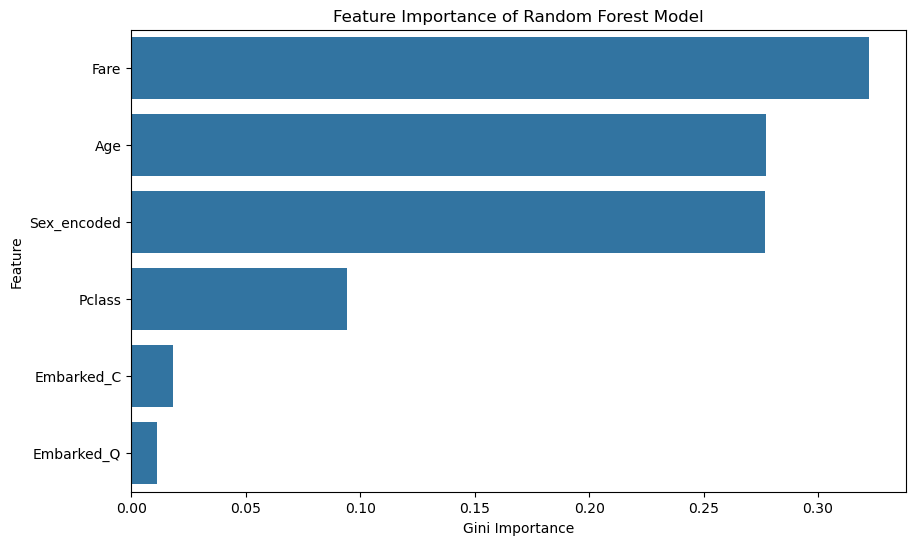

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(data=feature_imp_df, x='Gini Importance', y='Feature')
plt.title('Feature Importance of Random Forest Model')
plt.show()


## Which feature is the most important for predicting survival?
From the above the Fare is the most important feature for predicting the survival (gini = 0.319384)

## 5. Tune the n_estimators (the number of trees in the model) and max_depth (the maximum depth of each tree) parameters.


In [81]:

# Define parameter ranges to test
n_estimators_list = [10, 50, 100, 200]
max_depth_list = [5, 10, 15, 20, None]

# Store results
results = []

for n in n_estimators_list:
    for depth in max_depth_list:
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'n_estimators': n,
            'max_depth': depth,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        print(f"n_estimators={n}, max_depth={depth} → Accuracy={accuracy:.4f}, F1={f1:.4f}")

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Find the best combination
best_model = results_df.loc[results_df['accuracy'].idxmax()]
print("\n Best model parameters:")
print(best_model)


n_estimators=10, max_depth=5 → Accuracy=0.7821, F1=0.7761
n_estimators=10, max_depth=10 → Accuracy=0.8156, F1=0.8135
n_estimators=10, max_depth=15 → Accuracy=0.8045, F1=0.8033
n_estimators=10, max_depth=20 → Accuracy=0.8156, F1=0.8146
n_estimators=10, max_depth=None → Accuracy=0.8156, F1=0.8146
n_estimators=50, max_depth=5 → Accuracy=0.8156, F1=0.8121
n_estimators=50, max_depth=10 → Accuracy=0.8268, F1=0.8253
n_estimators=50, max_depth=15 → Accuracy=0.8045, F1=0.8038
n_estimators=50, max_depth=20 → Accuracy=0.8212, F1=0.8208
n_estimators=50, max_depth=None → Accuracy=0.8212, F1=0.8208
n_estimators=100, max_depth=5 → Accuracy=0.8212, F1=0.8167
n_estimators=100, max_depth=10 → Accuracy=0.8324, F1=0.8307
n_estimators=100, max_depth=15 → Accuracy=0.8101, F1=0.8092
n_estimators=100, max_depth=20 → Accuracy=0.7933, F1=0.7926
n_estimators=100, max_depth=None → Accuracy=0.7989, F1=0.7985
n_estimators=200, max_depth=5 → Accuracy=0.8212, F1=0.8167
n_estimators=200, max_depth=10 → Accuracy=0.8324

## 6. Report the accuracy of all models and report which model performed the best, including the values for n_estimators and max_depth that the best model had.

Best model parameters:
n_estimator = 100
max_depth = 10
These resulted in an accuracy score of 0.832, which was an improvement on the default values where no parameters were specified.

Model Output:
n_estimators=10, max_depth=5 → Accuracy=0.7821, F1=0.7761
n_estimators=10, max_depth=10 → Accuracy=0.8156, F1=0.8135
n_estimators=10, max_depth=15 → Accuracy=0.8045, F1=0.8033
n_estimators=10, max_depth=20 → Accuracy=0.8156, F1=0.8146
n_estimators=10, max_depth=None → Accuracy=0.8156, F1=0.8146
n_estimators=50, max_depth=5 → Accuracy=0.8156, F1=0.8121
n_estimators=50, max_depth=10 → Accuracy=0.8268, F1=0.8253
n_estimators=50, max_depth=15 → Accuracy=0.8045, F1=0.8038
n_estimators=50, max_depth=20 → Accuracy=0.8212, F1=0.8208
n_estimators=50, max_depth=None → Accuracy=0.8212, F1=0.8208
n_estimators=100, max_depth=5 → Accuracy=0.8212, F1=0.8167
n_estimators=100, max_depth=10 → Accuracy=0.8324, F1=0.8307
n_estimators=100, max_depth=15 → Accuracy=0.8101, F1=0.8092
n_estimators=100, max_depth=20 → Accuracy=0.7933, F1=0.7926
n_estimators=100, max_depth=None → Accuracy=0.7989, F1=0.7985
n_estimators=200, max_depth=5 → Accuracy=0.8212, F1=0.8167
n_estimators=200, max_depth=10 → Accuracy=0.8324, F1=0.8312
n_estimators=200, max_depth=15 → Accuracy=0.7933, F1=0.7931
n_estimators=200, max_depth=20 → Accuracy=0.7933, F1=0.7931
n_estimators=200, max_depth=None → Accuracy=0.7989, F1=0.7985

# Grid search to see how it fine tunes the hyperparameters compared to the above.

In [ ]:
from sklearn.model_selection import GridSearchCV 
params = { 'max_depth': [2,3,5,10,20], 'min_samples_split': [5,10,20,50,100,200], 'max_features': [1,2,3,4,5,6] }

# Instantiate the grid search model 
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy") 
grid_search.fit(X_train, y_train)
# Check best-scoring hyperparameters 
print(grid_search.best_score_) 
rf_best = grid_search.best_estimator_ 
print(rf_best)

Fitting 4 folds for each of 210 candidates, totalling 840 fits
0.8370786516853932
RandomForestClassifier(max_depth=10, max_features=3, min_samples_split=20)


This gave a slightly better accuracy than the results from 5.